Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


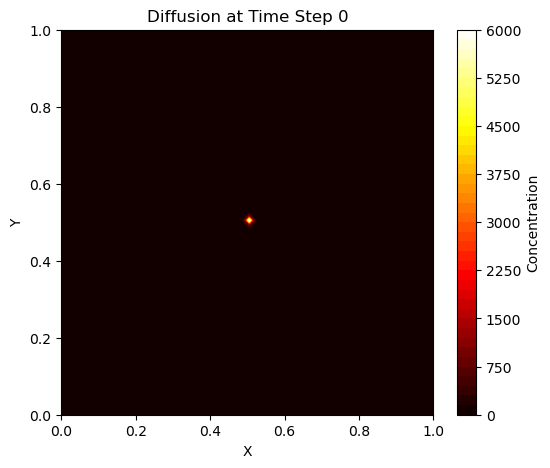

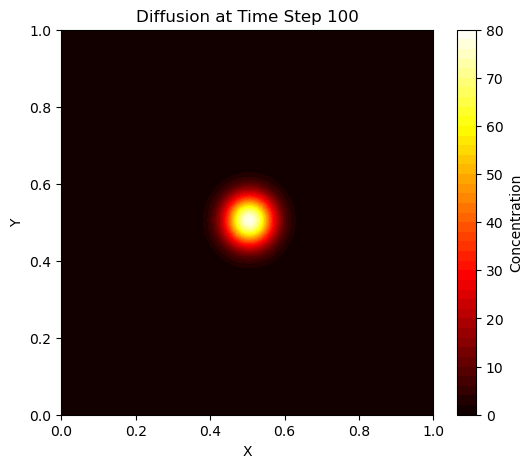

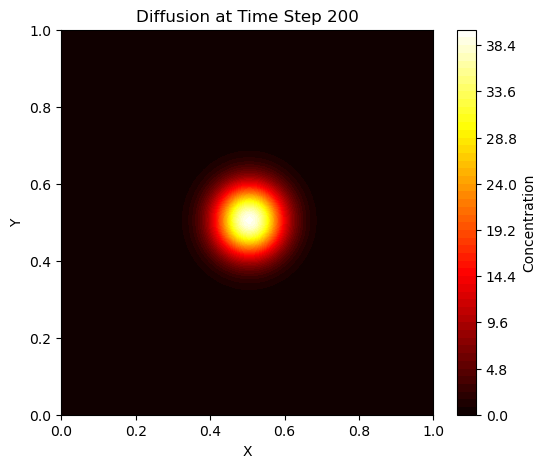

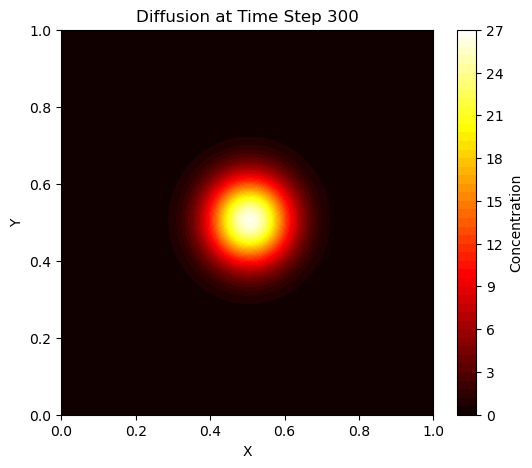

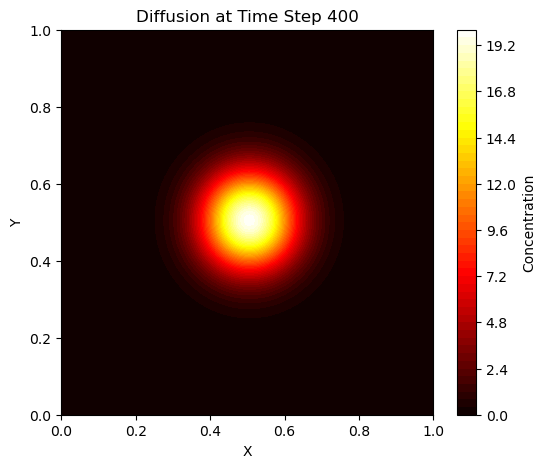

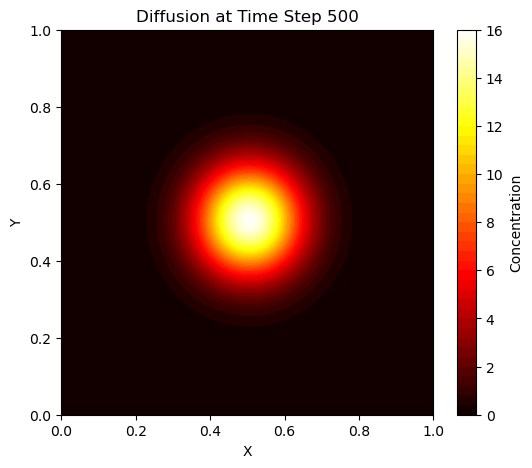

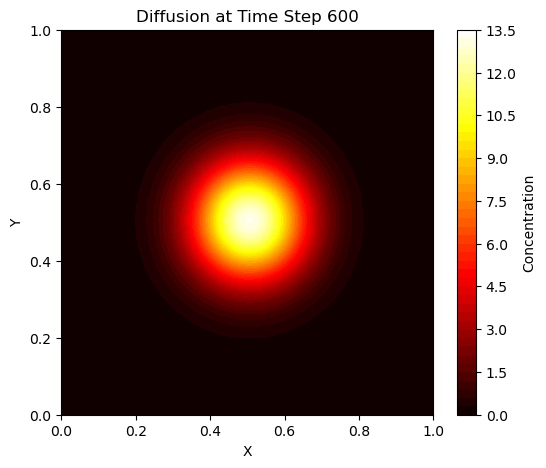

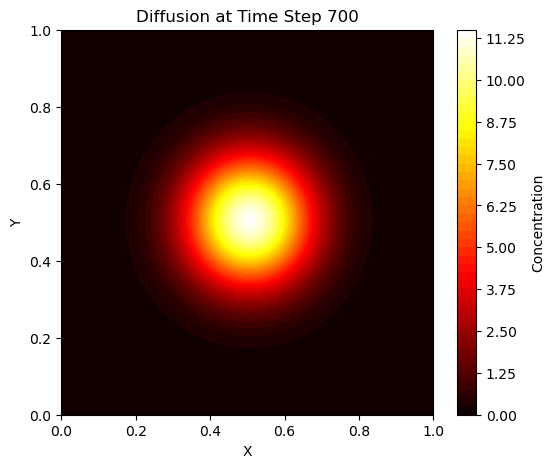

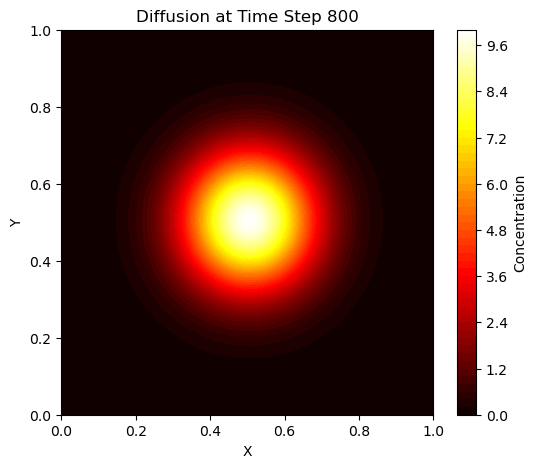

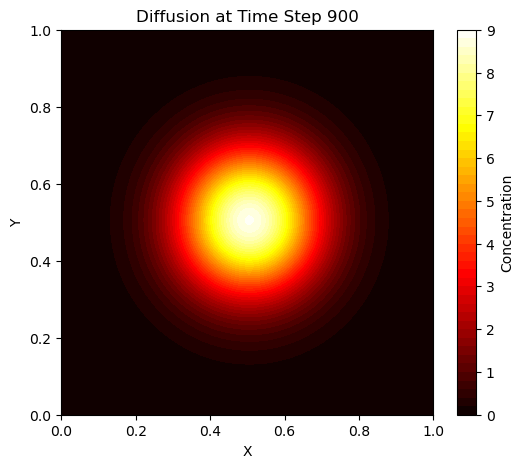

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Enable 64-bit precision if needed
jax.config.update("jax_enable_x64", True)

# 1. Set Up the Grid and Parameters
Lx, Ly = 1.0, 1.0  # Domain size
Nx, Ny = 100, 100  # Number of grid points
dx, dy = Lx / Nx, Ly / Ny
dt = 0.0001  # Time step
D = 0.1  # Diffusion coefficient
num_steps = 1000  # Number of time steps

x = jnp.linspace(0, Lx, Nx)
y = jnp.linspace(0, Ly, Ny)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# 2. Initialize the Concentration Field
C = jnp.zeros((Nx, Ny))
# Place a point source at the center
center_x, center_y = Nx // 2, Ny // 2
C = C.at[center_x, center_y].set(1.0 / (dx * dy))


# 3. Define the Laplacian Operator
def laplacian(C):
    C_up = jnp.roll(C, -1, axis=0)
    C_down = jnp.roll(C, 1, axis=0)
    C_left = jnp.roll(C, -1, axis=1)
    C_right = jnp.roll(C, 1, axis=1)
    laplacian_C = (C_up + C_down + C_left + C_right - 4 * C) / (dx * dy)
    return laplacian_C


# 4. Time-Stepping Function
@jax.jit
def update(C):
    C_new = C + D * dt * laplacian(C)
    return C_new


# 5. Run the Simulation
C_list = []
for step in range(num_steps):
    C = update(C)
    if step % 100 == 0:
        C_list.append(C)

# 6. Visualization
for i, C_snapshot in enumerate(C_list):
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, C_snapshot, levels=50, cmap="hot")
    plt.colorbar(label="Concentration")
    plt.title(f"Diffusion at Time Step {i * 100}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

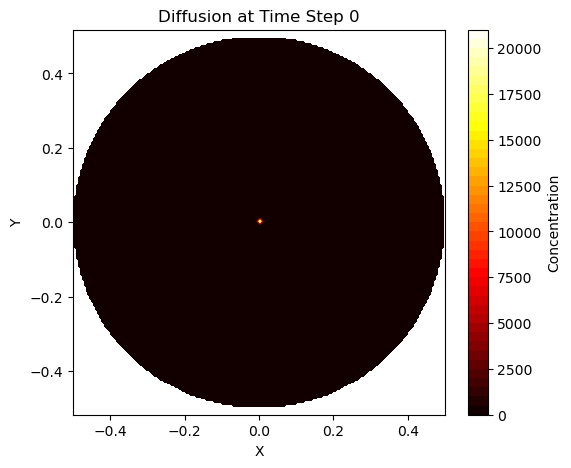

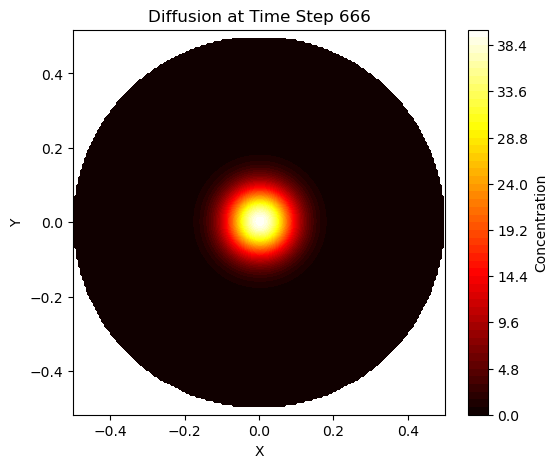

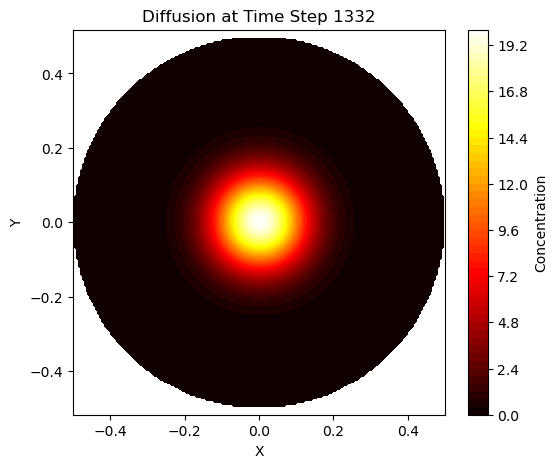

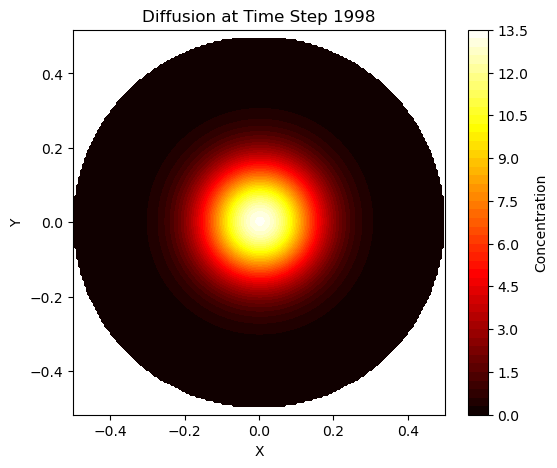

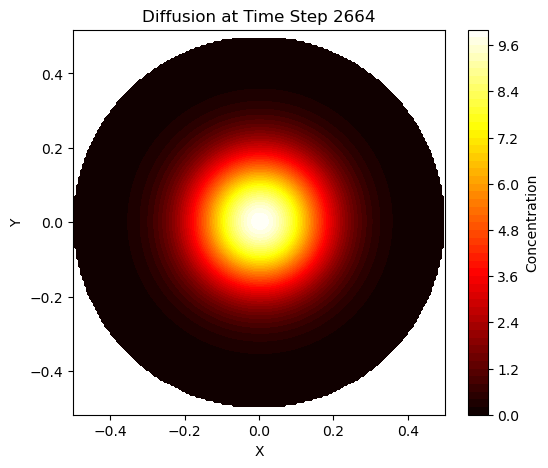

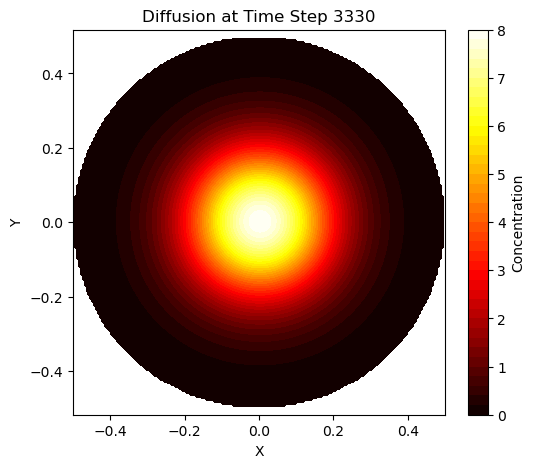

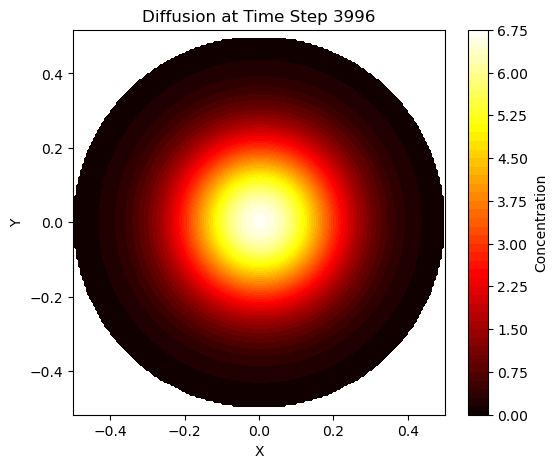

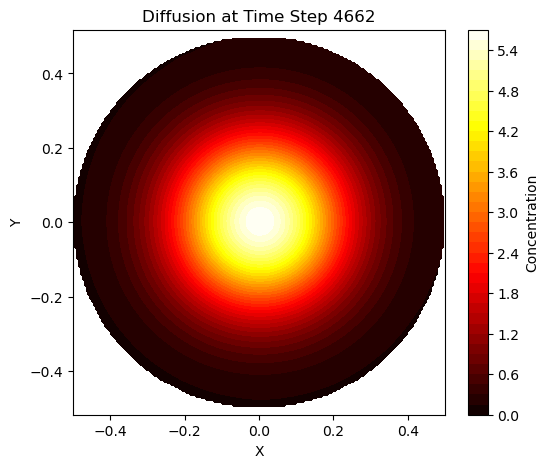

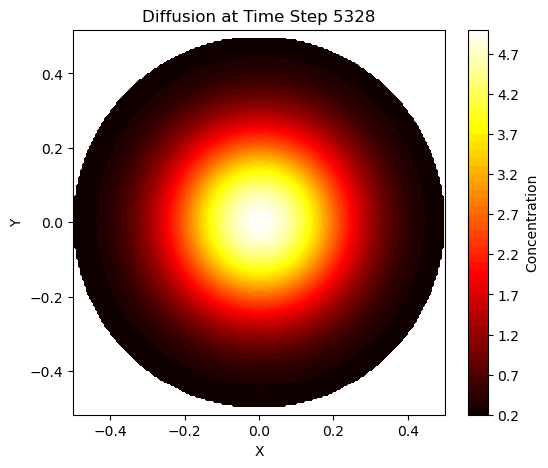

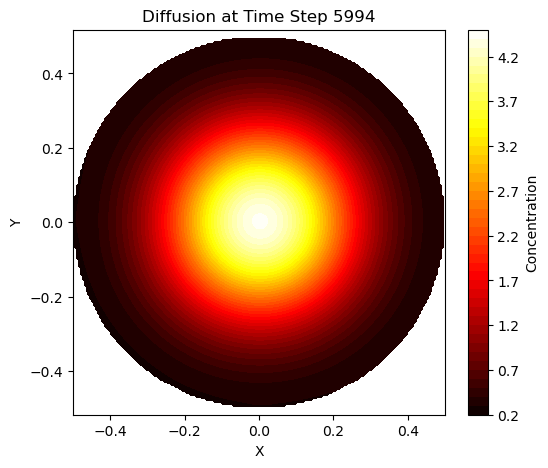

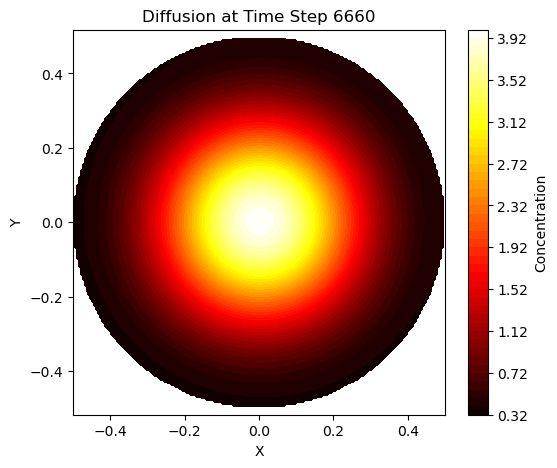

In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Enable 64-bit precision if needed
jax.config.update("jax_enable_x64", True)

# 1. Set Up the Grid and Parameters
Lx, Ly = 1.0, 1.0  # Domain size
Nx, Ny = 200, 200  # Number of grid points
dx = Lx / Nx
dt = 0.00003  # Reduced time step
D = 0.1  # Diffusion coefficient
num_steps = 6667  # Adjusted number of time steps

# Create the spatial grid
x = jnp.linspace(-Lx / 2, Lx / 2, Nx)
y = jnp.linspace(-Ly / 2, Ly / 2, Ny)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# 2. Define the Circular Domain
radius = Lx / 2  # Circle radius
distance = jnp.sqrt(X**2 + Y**2)
mask = jnp.where(distance <= radius, 1.0, 0.0)

# 3. Initialize the Concentration Field
C = jnp.zeros((Nx, Ny))
# Place a point source at the center
center_x, center_y = Nx // 2, Ny // 2
C = C.at[center_x, center_y].set(1.0 / (dx * dx))


# 4. Define the Laplacian Operator with Neumann Boundary Conditions
def laplacian(C, mask):
    # Pad the array to handle boundary conditions
    C_padded = jnp.pad(C, pad_width=1, mode="edge")
    mask_padded = jnp.pad(mask, pad_width=1, mode="constant", constant_values=0)

    # Extract central and neighboring values
    C_center = C_padded[1:-1, 1:-1]
    mask_center = mask_padded[1:-1, 1:-1]

    C_up = C_padded[2:, 1:-1]
    mask_up = mask_padded[2:, 1:-1]

    C_down = C_padded[:-2, 1:-1]
    mask_down = mask_padded[:-2, 1:-1]

    C_left = C_padded[1:-1, :-2]
    mask_left = mask_padded[1:-1, :-2]

    C_right = C_padded[1:-1, 2:]
    mask_right = mask_padded[1:-1, 2:]

    # Apply Neumann boundary conditions (zero normal derivative)
    C_up = jnp.where(mask_up, C_up, C_center)
    C_down = jnp.where(mask_down, C_down, C_center)
    C_left = jnp.where(mask_left, C_left, C_center)
    C_right = jnp.where(mask_right, C_right, C_center)

    # Compute the Laplacian
    laplacian_C = (C_up + C_down + C_left + C_right - 4 * C_center) / (dx * dx)

    # Only compute inside the circle
    laplacian_C = jnp.where(mask_center, laplacian_C, 0.0)

    return laplacian_C


# 5. Time-Stepping Function
@jax.jit
def update(C, mask):
    C_new = C + D * dt * laplacian(C, mask)
    return C_new


# 6. Run the Simulation
C_list = []
snapshot_interval = num_steps // 10  # Adjust snapshot interval if desired
for step in range(num_steps):
    C = update(C, mask)
    if step % snapshot_interval == 0:
        C_list.append(C)

# 7. Visualization
for i, C_snapshot in enumerate(C_list):
    # Mask out values outside the circle for visualization
    C_display = jnp.where(mask == 1, C_snapshot, jnp.nan)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, C_display, levels=50, cmap="hot")
    plt.colorbar(label="Concentration")
    plt.title(f"Diffusion at Time Step {i * snapshot_interval}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.show()

Step 0
Step 200
Step 400
Step 600
Step 800
Step 1000
Step 1200
Step 1400
Step 1600
Step 1800


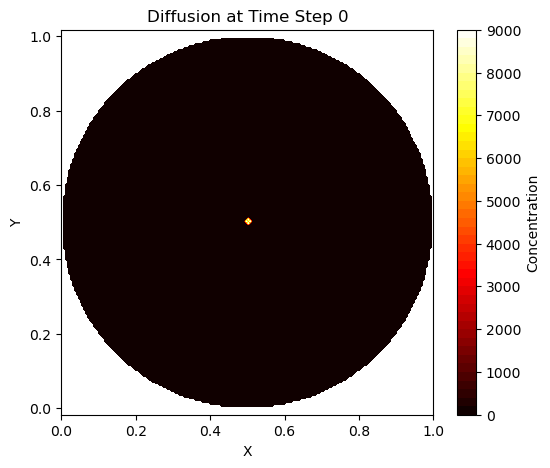

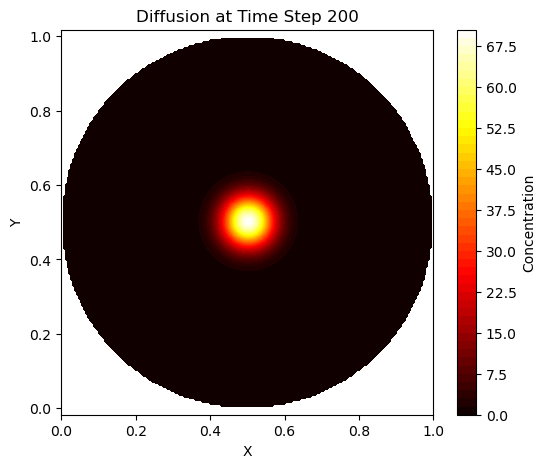

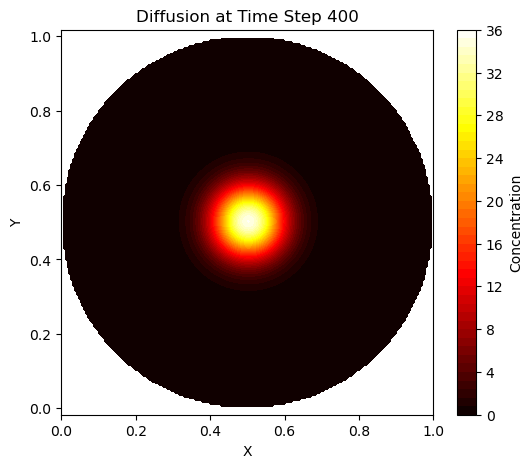

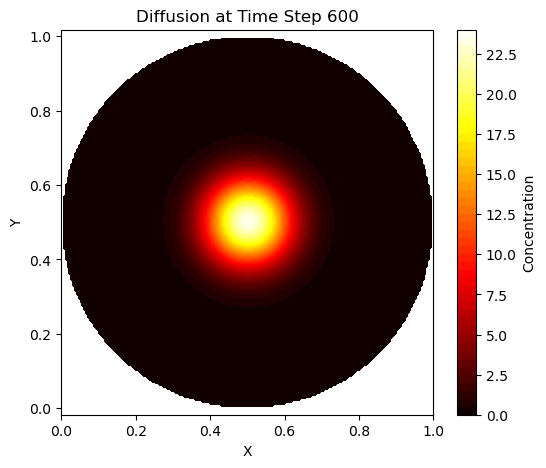

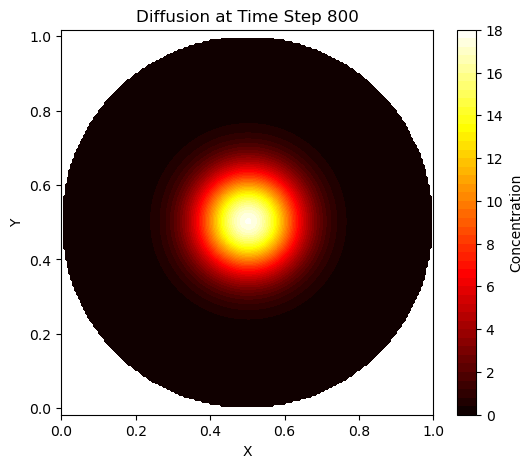

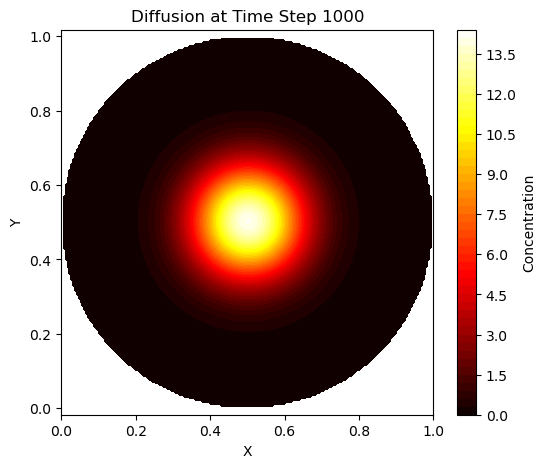

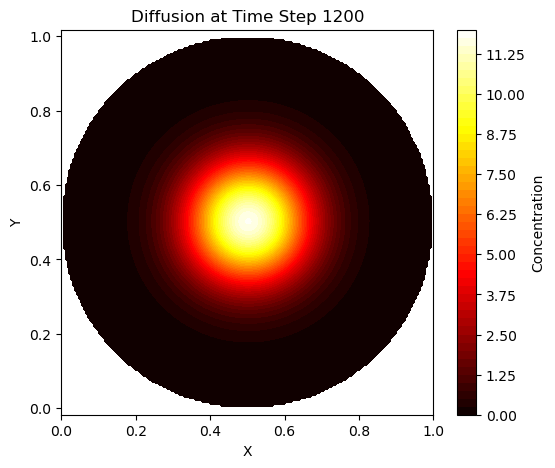

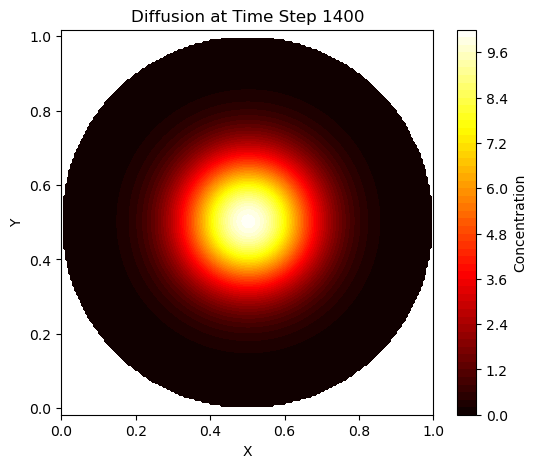

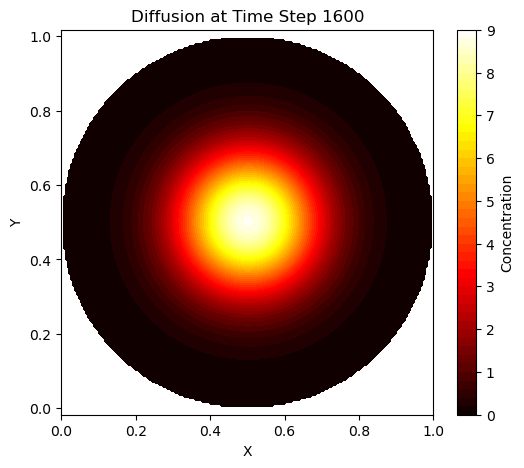

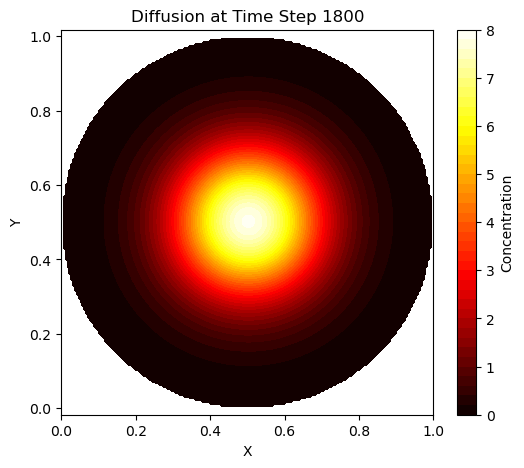

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


def simulate_diffusion(
    source_point, mask, D=0.1, dt=None, num_steps=1000, snapshot_interval=100
):
    """
    Simulate diffusion on a 2D grid with a user-provided source point and mask.

    Parameters:
    - source_point: Tuple of (x_index, y_index) where the initial concentration is placed.
    - mask: 2D numpy array defining the domain (1 inside, 0 outside).
    - D: Diffusion coefficient (default 0.1).
    - dt: Time step. If None, it will be set based on stability criteria.
    - num_steps: Total number of time steps to simulate.
    - snapshot_interval: Interval at which snapshots of the concentration field are stored.

    Returns:
    - C_list: List of concentration fields at specified intervals.
    - X, Y: Meshgrid arrays for plotting.
    """
    # Enable 64-bit precision if needed
    jax.config.update("jax_enable_x64", True)

    # Get grid dimensions from the mask
    Nx, Ny = mask.shape
    Lx, Ly = 1.0, 1.0  # Physical dimensions (can be adjusted)
    dx = Lx / Nx

    # Set time step based on stability condition if not provided
    if dt is None:
        dt = dx * dx / (4 * D) * 0.9  # 90% of max stable dt

    # Create the spatial grid
    x = jnp.linspace(0, Lx, Nx)
    y = jnp.linspace(0, Ly, Ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    # Initialize the Concentration Field
    C = jnp.zeros((Nx, Ny))
    # Place a point source at the specified location
    source_x, source_y = source_point
    C = C.at[source_x, source_y].set(1.0 / (dx * dx))

    # Define the Laplacian Operator with Neumann Boundary Conditions
    def laplacian(C, mask):
        # Pad the array to handle boundary conditions
        C_padded = jnp.pad(C, pad_width=1, mode="edge")
        mask_padded = jnp.pad(mask, pad_width=1, mode="constant", constant_values=0)

        # Extract central and neighboring values
        C_center = C_padded[1:-1, 1:-1]
        mask_center = mask_padded[1:-1, 1:-1]

        C_up = C_padded[2:, 1:-1]
        mask_up = mask_padded[2:, 1:-1]

        C_down = C_padded[:-2, 1:-1]
        mask_down = mask_padded[:-2, 1:-1]

        C_left = C_padded[1:-1, :-2]
        mask_left = mask_padded[1:-1, :-2]

        C_right = C_padded[1:-1, 2:]
        mask_right = mask_padded[1:-1, 2:]

        # Apply Neumann boundary conditions (zero normal derivative)
        C_up = jnp.where(mask_up, C_up, C_center)
        C_down = jnp.where(mask_down, C_down, C_center)
        C_left = jnp.where(mask_left, C_left, C_center)
        C_right = jnp.where(mask_right, C_right, C_center)

        # Compute the Laplacian
        laplacian_C = (C_up + C_down + C_left + C_right - 4 * C_center) / (dx * dx)

        # Only compute inside the domain
        laplacian_C = jnp.where(mask_center, laplacian_C, 0.0)

        return laplacian_C

    # Time-Stepping Function
    @jax.jit
    def update(C, mask):
        C_new = C + D * dt * laplacian(C, mask)
        return C_new

    # Run the Simulation
    C_list = []
    for step in range(num_steps):
        C = update(C, mask)
        if step % snapshot_interval == 0:
            C_list.append(C)
            print(f"Step {step}")

    return C_list, X, Y


# Example Usage
if __name__ == "__main__":
    # Define grid size
    Nx, Ny = 200, 200

    # Create a circular mask
    x = np.linspace(0, 1.0, Nx)
    y = np.linspace(0, 1.0, Ny)
    X, Y = np.meshgrid(x, y, indexing="ij")
    radius = 0.5
    distance = np.sqrt((X - 0.5) ** 2 + (Y - 0.5) ** 2)
    mask = np.where(distance <= radius, 1.0, 0.0)

    # Define source point (center of the grid)
    source_point = (Nx // 2, Ny // 2)


    # Run the simulation
    C_list, X_grid, Y_grid = simulate_diffusion(
        source_point=source_point,
        mask=mask,
        D=0.1,
        num_steps=2000,
        snapshot_interval=200,
    )

    # Visualization
    for i, C_snapshot in enumerate(C_list):
        # Mask out values outside the domain for visualization
        C_display = np.where(mask == 1, C_snapshot, np.nan)

        plt.figure(figsize=(6, 5))
        plt.contourf(X_grid, Y_grid, C_display, levels=50, cmap="hot")
        plt.colorbar(label="Concentration")
        plt.title(f"Diffusion at Time Step {i * 200}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis("equal")
        plt.show()

Step 0/22223
Step 1000/22223
Step 2000/22223
Step 3000/22223
Step 4000/22223
Step 5000/22223
Step 6000/22223
Step 7000/22223
Step 8000/22223
Step 9000/22223
Step 10000/22223
Step 11000/22223
Step 12000/22223
Step 13000/22223
Step 14000/22223
Step 15000/22223
Step 16000/22223
Step 17000/22223
Step 18000/22223
Step 19000/22223
Step 20000/22223
Step 21000/22223
Step 22000/22223
Step 22222/22223


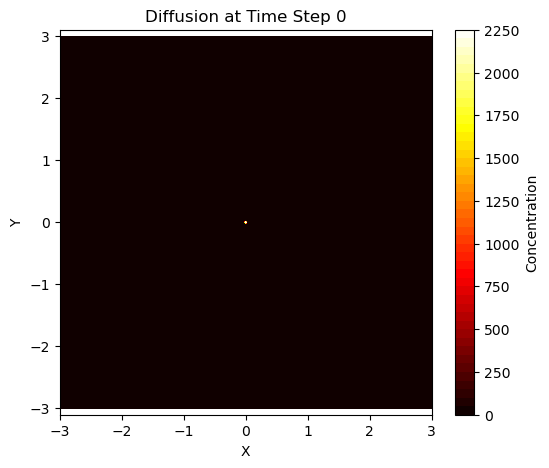

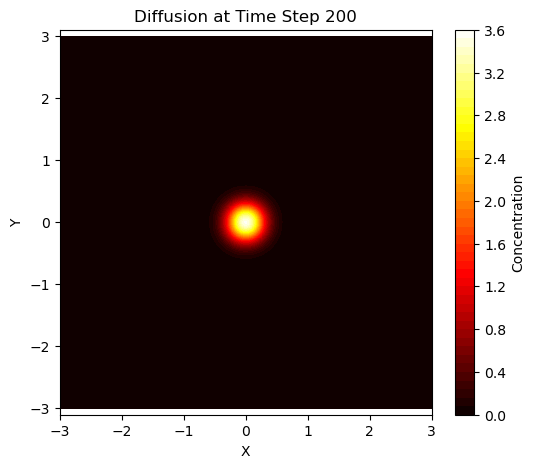

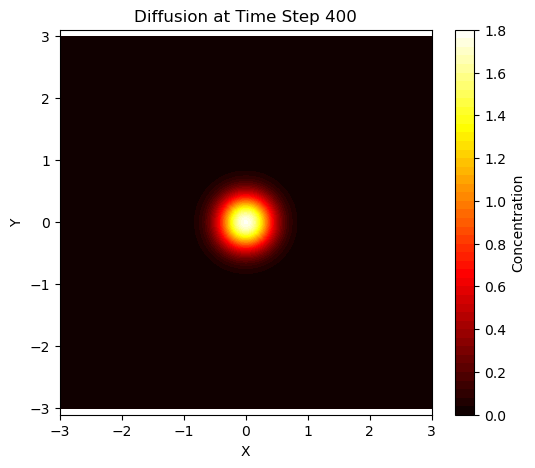

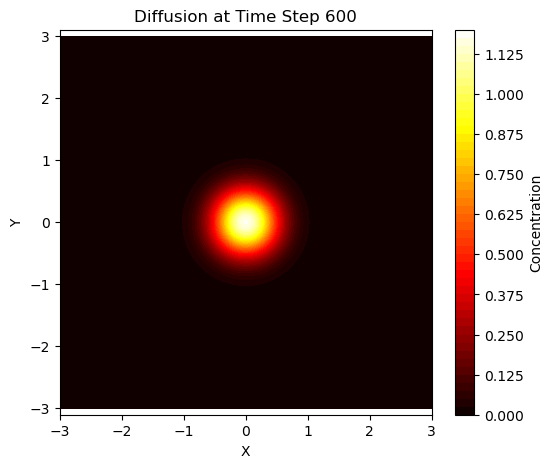

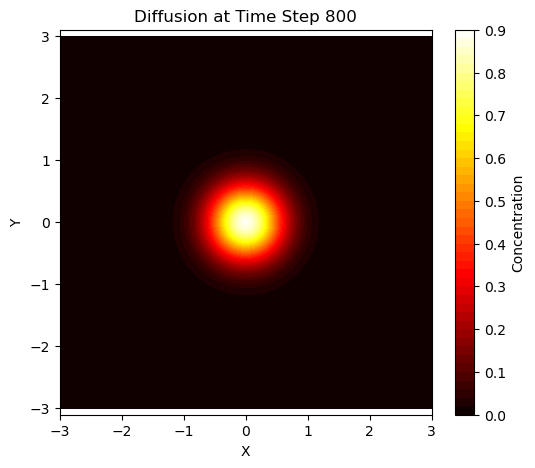

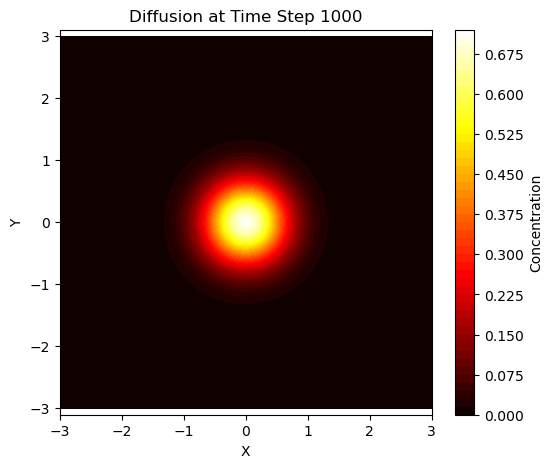

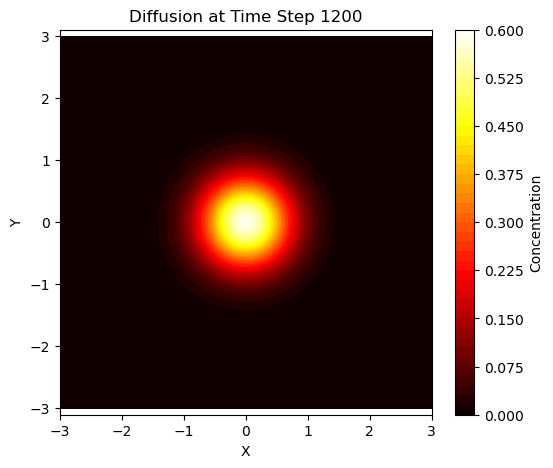

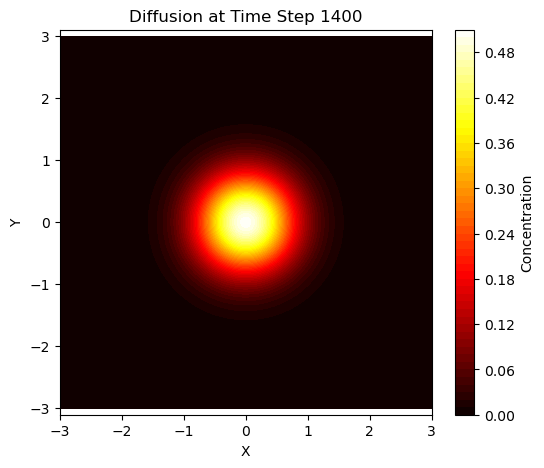

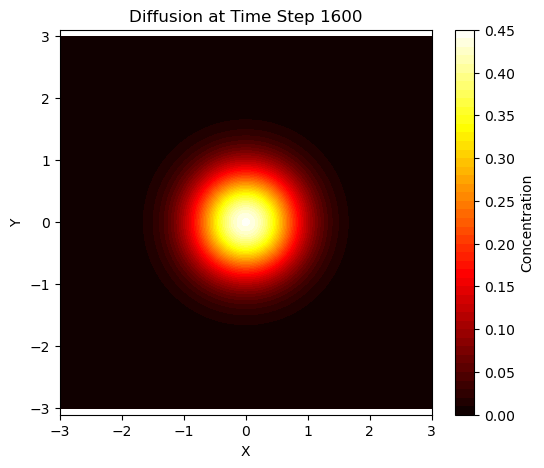

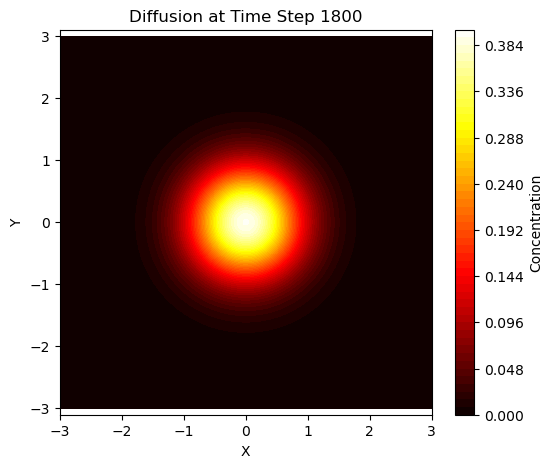

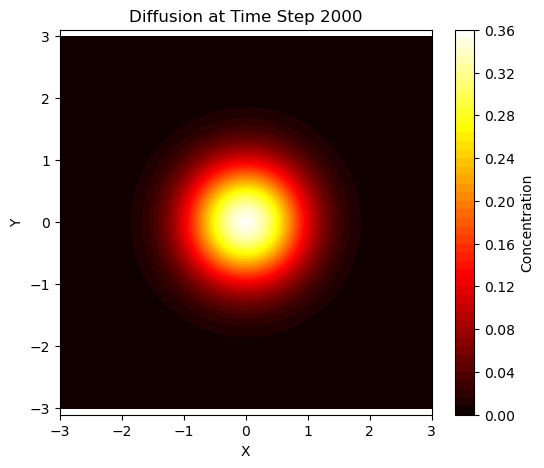

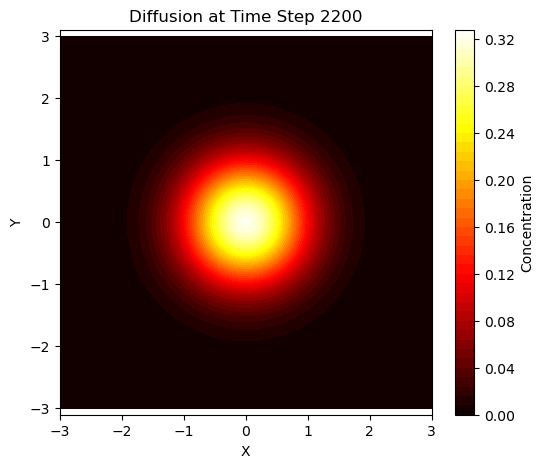

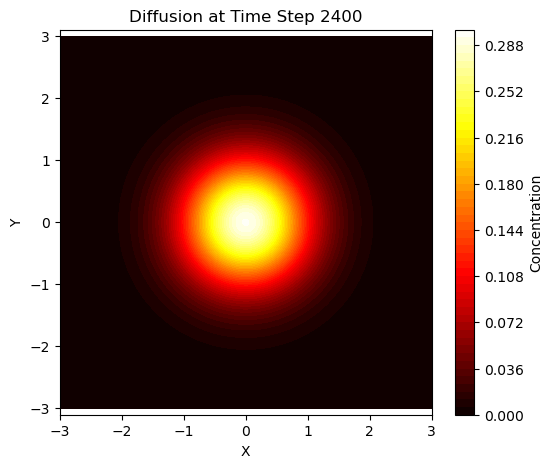

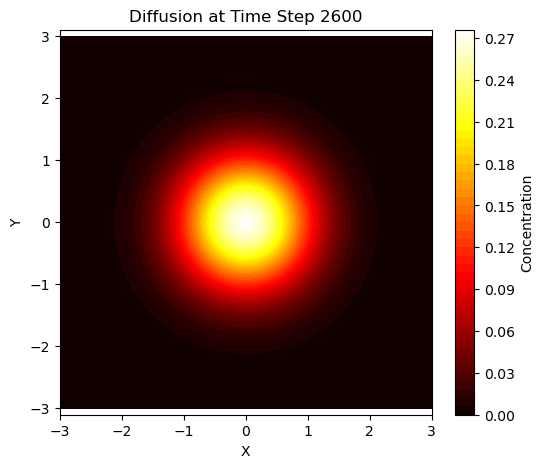

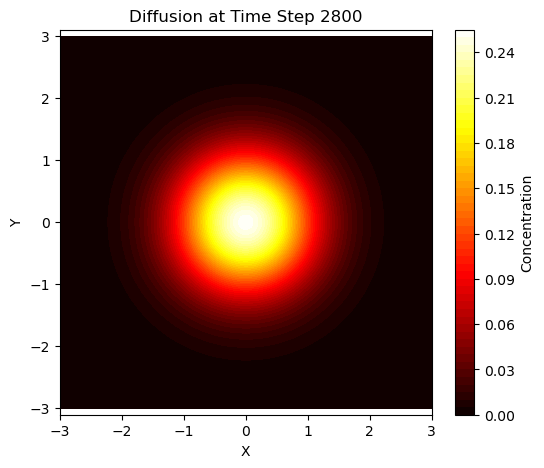

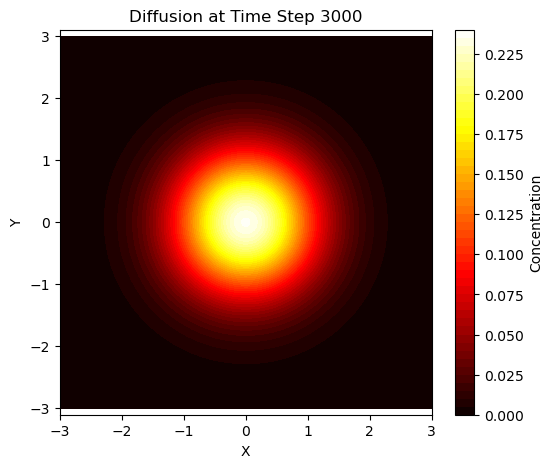

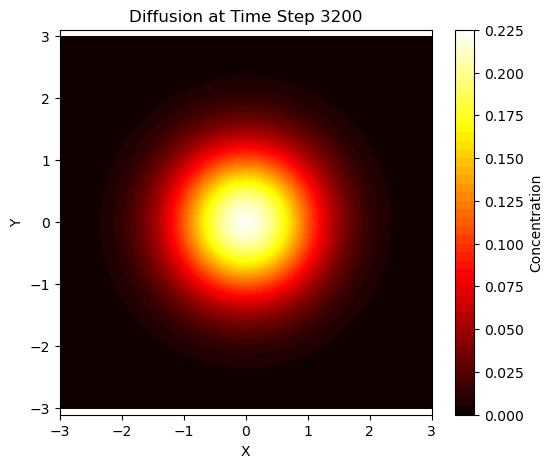

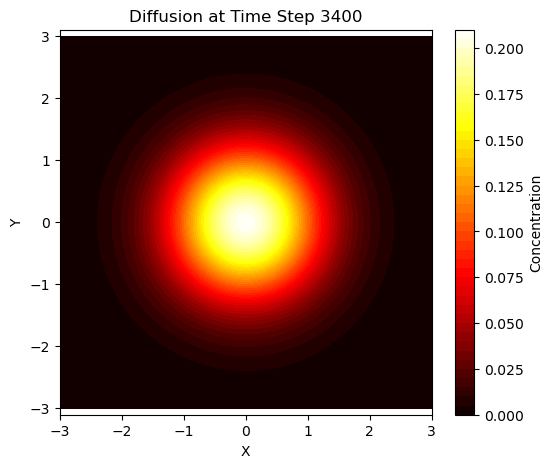

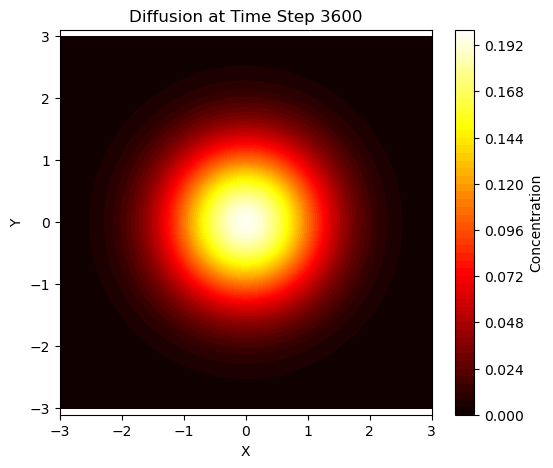

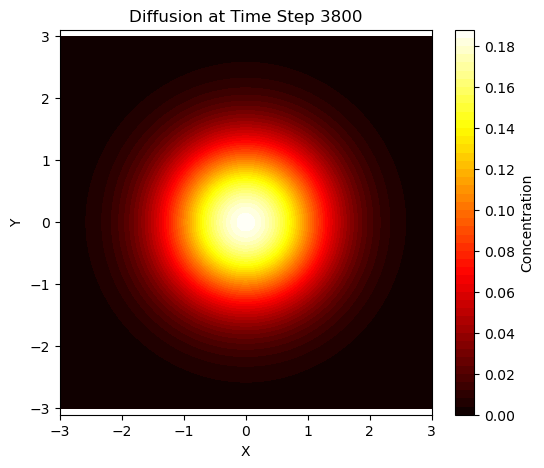

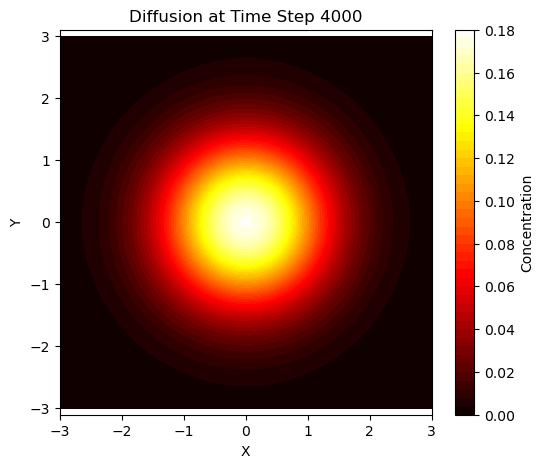

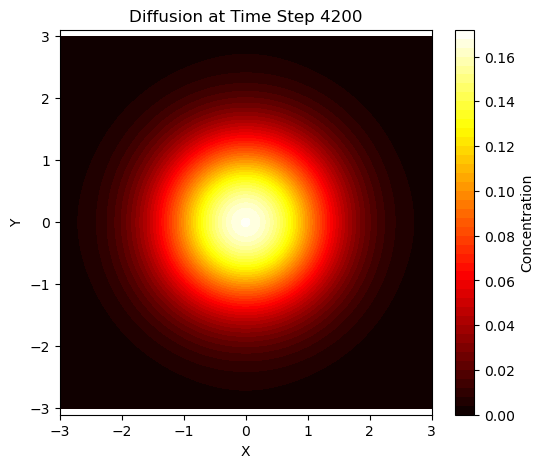

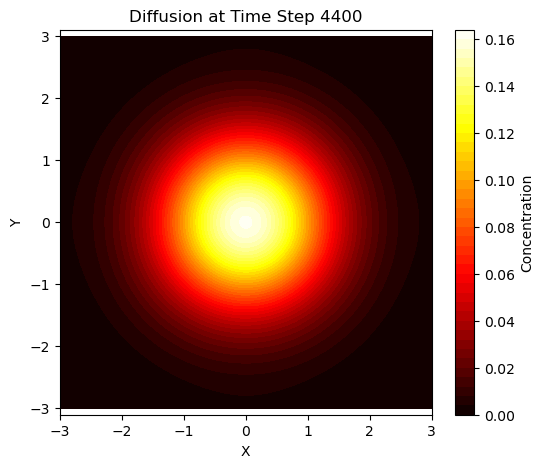

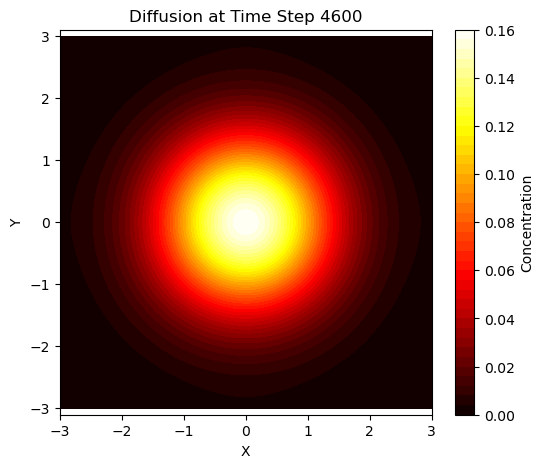

In [9]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


def simulate_diffusion_gaussian_sigma(
    sigma,
    D=0.1,
    dx=0.01,
    safety_factor=0.9,
    snapshot_interval=100,
    source_point=None,
    mask=None,
):
    """
    Simulate diffusion to achieve a Gaussian distribution with specified standard deviation,
    incorporating a user-provided mask and source point.

    Parameters:
    - sigma: Desired standard deviation of the Gaussian distribution.
    - D: Diffusion coefficient.
    - dx: Spatial grid spacing.
    - safety_factor: Fraction of the maximum stable dt to use.
    - snapshot_interval: Interval at which snapshots are stored.
    - source_point: Tuple (x_index, y_index) for the initial concentration point.
                    If None, it's set to the center of the grid.
    - mask: 2D numpy array defining the domain (1 inside, 0 outside).
            If None, the mask will cover the entire grid.

    Returns:
    - C_list: List of concentration fields at specified intervals.
    - X, Y: Meshgrid arrays for plotting.
    - dx: Spatial grid spacing (might be adjusted).
    """
    # Enable 64-bit precision if needed
    jax.config.update("jax_enable_x64", True)

    # 1. Calculate total simulation time t from sigma
    t_total = sigma**2 / (2 * D)

    # 2. Determine domain size based on mask or sigma
    if mask is not None:
        # Use mask dimensions to define the grid
        Nx, Ny = mask.shape
        Lx = dx * Nx
        Ly = dx * Ny
        x = jnp.linspace(-Lx / 2 + dx / 2, Lx / 2 - dx / 2, Nx)
        y = jnp.linspace(-Ly / 2 + dx / 2, Ly / 2 - dx / 2, Ny)
    else:
        # Set domain size to minimize boundary effects
        Lx = Ly = 6 * sigma  # Total length in x and y directions
        Nx = Ny = int(Lx / dx)
        if Nx % 2 == 0:
            Nx += 1  # Ensure odd number of points to have a center point
        if Ny % 2 == 0:
            Ny += 1
        x = jnp.linspace(-Lx / 2, Lx / 2, Nx)
        y = jnp.linspace(-Ly / 2, Ly / 2, Ny)
        # Create a full mask
        mask = jnp.ones((Nx, Ny))

    # Recalculate dx to fit the domain size precisely
    dx = x[1] - x[0]

    # 3. Set up the spatial grid
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    # 4. Compute dt based on stability condition
    dt = safety_factor * dx * dx / (4 * D)

    # 5. Calculate the number of time steps
    num_steps = int(np.ceil(t_total / dt))

    # Adjust dt to exactly reach t_total
    dt = t_total / num_steps

    # 6. Initialize the concentration field
    C = jnp.zeros((Nx, Ny))

    # Set the source point
    if source_point is None:
        source_x, source_y = Nx // 2, Ny // 2
    else:
        source_x, source_y = source_point
    C = C.at[source_x, source_y].set(1.0 / (dx * dx))

    # Ensure the source point is within the mask
    if mask[source_x, source_y] == 0:
        raise ValueError("The source point is outside the domain defined by the mask.")

    # 7. Define the Laplacian operator with periodic boundary conditions
    def laplacian(C, mask):
        # Pad the array to handle boundary conditions
        C_padded = jnp.pad(C, pad_width=1, mode="wrap")  # Periodic boundaries
        mask_padded = jnp.pad(mask, pad_width=1, mode="wrap")

        # Extract central and neighboring values
        C_center = C_padded[1:-1, 1:-1]
        mask_center = mask_padded[1:-1, 1:-1]

        C_up = C_padded[2:, 1:-1]
        mask_up = mask_padded[2:, 1:-1]

        C_down = C_padded[:-2, 1:-1]
        mask_down = mask_padded[:-2, 1:-1]

        C_left = C_padded[1:-1, :-2]
        mask_left = mask_padded[1:-1, :-2]

        C_right = C_padded[1:-1, 2:]
        mask_right = mask_padded[1:-1, 2:]

        # Apply mask to neighbors
        C_up = jnp.where(mask_up, C_up, C_center)
        C_down = jnp.where(mask_down, C_down, C_center)
        C_left = jnp.where(mask_left, C_left, C_center)
        C_right = jnp.where(mask_right, C_right, C_center)

        # Compute the Laplacian
        laplacian_C = (C_up + C_down + C_left + C_right - 4 * C_center) / (dx * dx)

        # Only compute inside the domain
        laplacian_C = jnp.where(mask_center, laplacian_C, 0.0)

        return laplacian_C

    # 8. Time-stepping function
    @jax.jit
    def update(C, mask):
        C_new = C + D * dt * laplacian(C, mask)
        return C_new

    # 9. Run the simulation
    C_list = []
    for step in range(num_steps):
        C = update(C, mask)
        if step % snapshot_interval == 0 or step == num_steps - 1:
            C_list.append(C)
            print(f"Step {step}/{num_steps}")

    return C_list, X, Y, dx


# Example Usage
if __name__ == "__main__":
    # Desired standard deviation
    sigma_desired = 1.0

    # Define grid spacing
    dx = 0.01

    # Create a custom mask (e.g., an elliptical domain)
    Lx = Ly = 6 * sigma_desired
    Nx = Ny = int(Lx / dx)
    if Nx % 2 == 0:
        Nx += 1
    if Ny % 2 == 0:
        Ny += 1
    x = np.linspace(-Lx / 2, Lx / 2, Nx)
    y = np.linspace(-Ly / 2, Ly / 2, Ny)
    X, Y = np.meshgrid(x, y, indexing="ij")
    a, b = 2 * sigma_desired, sigma_desired  # Semi-major and semi-minor axes
    # mask = np.where(((X / a) ** 2 + (Y / b) ** 2) <= 1, 1.0, 0.0)
    mask = np.ones((Nx, Ny))

    # Define source point (center of the grid)
    source_point = (Nx // 2, Ny // 2)

    # Run the simulation
    C_list, X_grid, Y_grid, dx = simulate_diffusion_gaussian_sigma(
        sigma=sigma_desired,
        D=0.1,
        dx=dx,  # Spatial grid spacing
        safety_factor=0.9,
        snapshot_interval=1000,
        source_point=source_point,
        mask=mask,
    )

    # Visualization
    for i, C_snapshot in enumerate(C_list):
        # Mask out values outside the domain for visualization
        C_display = np.where(mask == 1, C_snapshot, np.nan)

        plt.figure(figsize=(6, 5))
        plt.contourf(X_grid, Y_grid, C_display, levels=50, cmap="hot")
        plt.colorbar(label="Concentration")
        plt.title(f"Diffusion at Time Step {i * 200}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis("equal")
        plt.show()

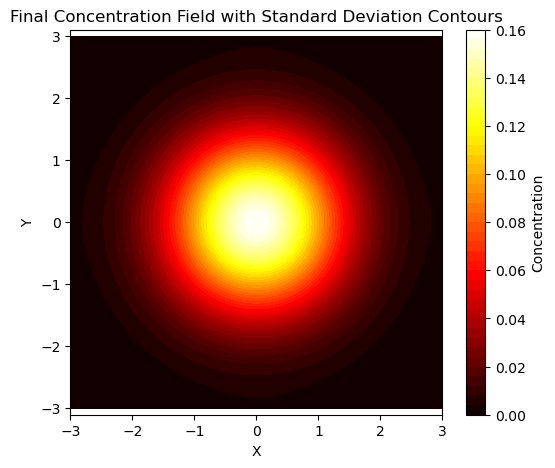

In [12]:
# Plot the final concentration field with standard deviation contours
C_final = C_list[-1]
C_display = np.where(mask == 1, C_final, np.nan)

plt.figure(figsize=(6, 5))
plt.contourf(X_grid, Y_grid, C_display, levels=50, cmap='hot')
plt.colorbar(label='Concentration')
plt.title('Final Concentration Field with Standard Deviation Contours')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')

# Compute squared distance from source point
x_source, y_source = source_point
R_squared = (X_grid - x_source)**2 + (Y_grid - y_source)**2

# Define standard deviation levels
k_values = [1, 2, 3]  # Multiples of sigma
contour_levels = [(k * sigma_desired)**2 for k in k_values]

# Plot the contours
CS = plt.contour(X_grid, Y_grid, R_squared, levels=contour_levels, colors='blue', linestyles='dashed', zorder=10)
plt.clabel(CS, inline=True, fmt={level: f'{k}\u03C3' for k, level in zip(k_values, contour_levels)}, fontsize=10)

plt.show()

Step 0/223
Step 200/223
Step 222/223


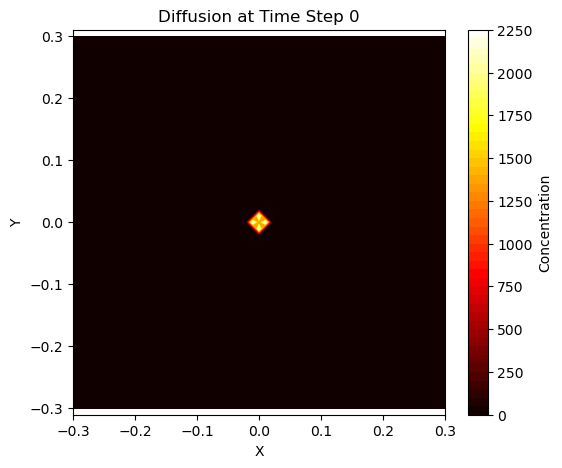

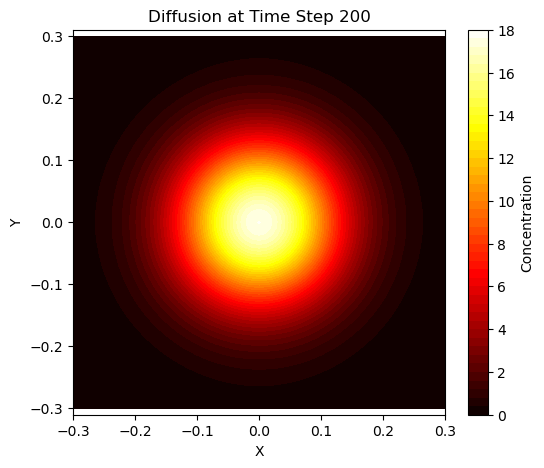

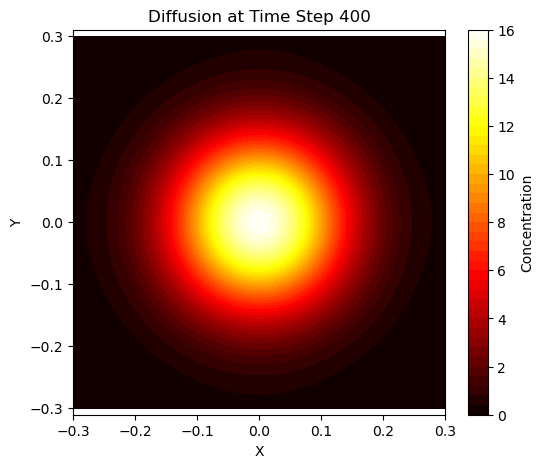

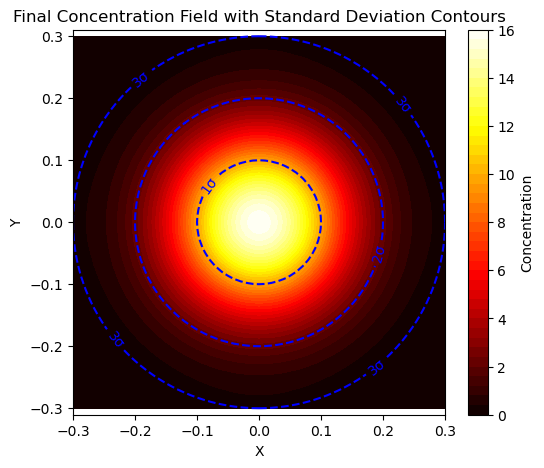

In [19]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


def simulate_diffusion_gaussian_sigma(
    sigma,
    D=0.1,
    dx=0.01,
    safety_factor=0.9,
    snapshot_interval=100,
    source_point=None,
    mask=None,
):
    """
    Simulate diffusion to achieve a Gaussian distribution with specified standard deviation,
    incorporating a user-provided mask and source point.

    Parameters:
    - sigma: Desired standard deviation of the Gaussian distribution.
    - D: Diffusion coefficient.
    - dx: Spatial grid spacing.
    - safety_factor: Fraction of the maximum stable dt to use.
    - snapshot_interval: Interval at which snapshots are stored.
    - source_point: Tuple (x_index, y_index) for the initial concentration point.
                    If None, it's set to the center of the grid.
    - mask: 2D numpy array defining the domain (1 inside, 0 outside).
            If None, the mask will cover the entire grid.

    Returns:
    - C_list: List of concentration fields at specified intervals.
    - X, Y: Meshgrid arrays for plotting.
    - dx: Spatial grid spacing (might be adjusted).
    - source_coords: Coordinates of the source point (x_source, y_source).
    """
    # Enable 64-bit precision if needed
    jax.config.update("jax_enable_x64", True)

    # 1. Calculate total simulation time t from sigma
    t_total = sigma**2 / (2 * D)

    # 2. Determine domain size based on mask or sigma
    if mask is not None:
        # Use mask dimensions to define the grid
        Nx, Ny = mask.shape
        Lx = dx * Nx
        Ly = dx * Ny
        x = jnp.linspace(-Lx / 2 + dx / 2, Lx / 2 - dx / 2, Nx)
        y = jnp.linspace(-Ly / 2 + dx / 2, Ly / 2 - dx / 2, Ny)
    else:
        # Set domain size to minimize boundary effects
        Lx = Ly = 6 * sigma  # Total length in x and y directions
        Nx = Ny = int(Lx / dx)
        if Nx % 2 == 0:
            Nx += 1  # Ensure odd number of points to have a center point
        if Ny % 2 == 0:
            Ny += 1
        x = jnp.linspace(-Lx / 2, Lx / 2, Nx)
        y = jnp.linspace(-Ly / 2, Ly / 2, Ny)
        # Create a full mask
        mask = jnp.ones((Nx, Ny))

    # Recalculate dx to fit the domain size precisely
    dx = x[1] - x[0]

    # 3. Set up the spatial grid
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    # 4. Compute dt based on stability condition
    dt = safety_factor * dx * dx / (4 * D)

    # 5. Calculate the number of time steps
    num_steps = int(np.ceil(t_total / dt))

    # Adjust dt to exactly reach t_total
    dt = t_total / num_steps

    # 6. Initialize the concentration field
    C = jnp.zeros((Nx, Ny))

    # Set the source point
    if source_point is None:
        source_x, source_y = Nx // 2, Ny // 2
    else:
        source_x, source_y = source_point
    C = C.at[source_x, source_y].set(1.0 / (dx * dx))

    # Ensure the source point is within the mask
    if mask[source_x, source_y] == 0:
        raise ValueError("The source point is outside the domain defined by the mask.")

    # Get coordinates of the source point
    x_source = x[source_x]
    y_source = y[source_y]
    source_coords = (x_source, y_source)

    # 7. Define the Laplacian operator with periodic boundary conditions and mask
    def laplacian(C, mask):
        # Pad the array to handle boundary conditions
        C_padded = jnp.pad(C, pad_width=1, mode="wrap")  # Periodic boundaries
        mask_padded = jnp.pad(mask, pad_width=1, mode="wrap")

        # Extract central and neighboring values
        C_center = C_padded[1:-1, 1:-1]
        mask_center = mask_padded[1:-1, 1:-1]

        C_up = C_padded[2:, 1:-1]
        mask_up = mask_padded[2:, 1:-1]

        C_down = C_padded[:-2, 1:-1]
        mask_down = mask_padded[:-2, 1:-1]

        C_left = C_padded[1:-1, :-2]
        mask_left = mask_padded[1:-1, :-2]

        C_right = C_padded[1:-1, 2:]
        mask_right = mask_padded[1:-1, 2:]

        # Apply mask to neighbors
        C_up = jnp.where(mask_up, C_up, C_center)
        C_down = jnp.where(mask_down, C_down, C_center)
        C_left = jnp.where(mask_left, C_left, C_center)
        C_right = jnp.where(mask_right, C_right, C_center)

        # Compute the Laplacian
        laplacian_C = (C_up + C_down + C_left + C_right - 4 * C_center) / (dx * dx)

        # Only compute inside the domain
        laplacian_C = jnp.where(mask_center, laplacian_C, 0.0)

        return laplacian_C

    # 8. Time-stepping function
    @jax.jit
    def update(C, mask):
        C_new = C + D * dt * laplacian(C, mask)
        return C_new

    # 9. Run the simulation
    C_list = []
    for step in range(num_steps):
        C = update(C, mask)
        if step % snapshot_interval == 0 or step == num_steps - 1:
            C_list.append(C)
            print(f"Step {step}/{num_steps}")

    return C_list, X, Y, dx, source_coords


# Example Usage
if __name__ == "__main__":
    # Desired standard deviation
    # sigma_desired = 1.0
    sigma_desired = 0.1

    # Define grid spacing
    dx = 0.01

    # Create a custom mask (e.g., an elliptical domain)
    Lx = Ly = 6 * sigma_desired
    Nx = Ny = int(Lx / dx)
    if Nx % 2 == 0:
        Nx += 1
    if Ny % 2 == 0:
        Ny += 1
    x = np.linspace(-Lx / 2, Lx / 2, Nx)
    y = np.linspace(-Ly / 2, Ly / 2, Ny)
    X, Y = np.meshgrid(x, y, indexing="ij")
    a, b = 2 * sigma_desired, sigma_desired  # Semi-major and semi-minor axes
    # mask = np.where(((X / a) ** 2 + (Y / b) ** 2) <= 1, 1.0, 0.0)
    mask = np.ones((Nx, Ny))

    # Define source point (center of the grid)
    source_point = (Nx // 2, Ny // 2)

    # Run the simulation
    C_list, X_grid, Y_grid, dx, source_coords = simulate_diffusion_gaussian_sigma(
        sigma=sigma_desired,
        D=0.1,
        dx=dx,  # Spatial grid spacing
        safety_factor=0.9,
        snapshot_interval=200,
        source_point=source_point,
        mask=mask,
    )

    # Visualization
    for i, C_snapshot in enumerate(C_list):
        # Mask out values outside the domain for visualization
        C_display = np.where(mask == 1, C_snapshot, np.nan)

        plt.figure(figsize=(6, 5))
        plt.contourf(X_grid, Y_grid, C_display, levels=50, cmap="hot")
        plt.colorbar(label="Concentration")
        plt.title(f"Diffusion at Time Step {i * 200}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis("equal")
        plt.show()

    # Plot the final concentration field with standard deviation contours
    C_final = C_list[-1]
    C_display = np.where(mask == 1, C_final, np.nan)

    plt.figure(figsize=(6, 5))
    plt.contourf(X_grid, Y_grid, C_display, levels=50, cmap="hot")
    plt.colorbar(label="Concentration")
    plt.title("Final Concentration Field with Standard Deviation Contours")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")

    # Compute squared distance from source point
    x_source, y_source = source_coords
    R_squared = (X_grid - x_source) ** 2 + (Y_grid - y_source) ** 2

    # Define standard deviation levels
    k_values = [1, 2, 3]  # Multiples of sigma
    contour_levels = [(k * sigma_desired) ** 2 for k in k_values]

    # Plot the contours
    CS = plt.contour(
        X_grid,
        Y_grid,
        R_squared,
        levels=contour_levels,
        colors="blue",
        linestyles="dashed",
    )
    plt.clabel(
        CS,
        inline=True,
        fmt={level: f"{k}\u03C3" for k, level in zip(k_values, contour_levels)},
        fontsize=10,
    )

    plt.show()